### This notebook is used to generate Figure1 and Figure S1

#### Figure 1A. Contamination rate in feature-barcoded techniques

In [1]:
import os
import pandas as pd
import seaborn as sns
from natsort import natsorted
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
import glob, re
import anndata as ad
import scanpy as sc

### Plot setting

In [2]:
#publication quality plots
from matplotlib import pylab

params = {'legend.fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (4, 3),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5, 
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'pdf.fonttype': 42,
         'figure.autolayout': True,
         'axes.grid':False,
         "figure.dpi":150}

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
pylab.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10});

# Set the font used for MathJax - more on this later
pylab.rc('mathtext',**{'default':'regular'});

pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

# %matplotlib inline

In [3]:
metadata = pd.read_csv('/da/ONC/BFx/research/shengca1/bioinfo_pipeline/manuscript/analysis/metadata.csv', index_col=0)

In [4]:
def get_total_counts(adata_obj, n_droplets=None):
    
    if n_droplets is None:
        mRNA = adata_obj[:, ~adata_obj.var['gene_ids'].str.contains('_')]   # only mRNA
        total_mRNA = mRNA.to_df().sum(axis=1).to_frame('mRNA')
        fb = adata_obj[:, (adata_obj.var['gene_ids'].str.contains('_')) & (~adata_obj.var['gene_ids'].str.contains('Cas9'))]   # only sgRNA, Cas9 construct excluded
        total_fb = fb.to_df().sum(axis=1).to_frame('feature_barcode')
    else:
        mRNA = adata_obj[:, ~adata_obj.var['gene_ids'].str.contains('_')]   # only mRNA
        sc.pp.calculate_qc_metrics(mRNA, inplace=True)
        # take only top n droplets to speed the computation
        mRNA = mRNA[mRNA.obs['total_counts'].nlargest(n_droplets).index]
        total_mRNA = mRNA.to_df().sum(axis=1).to_frame('mRNA')
        
        fb = adata_obj[:, (adata_obj.var['gene_ids'].str.contains('_')) & (~adata_obj.var['gene_ids'].str.contains('Cas9'))]   # only sgRNA, Cas9 construct excluded
        
        
#         [total_mRNA.index]
        total_fb = fb.to_df().sum(axis=1).to_frame('feature_barcode')
    
    return total_mRNA.join(total_fb, how='left').sort_values('mRNA')

In [51]:
def split(adata_obj, nlargest=None):
    
    mRNA = adata_obj[:, ~adata_obj.var['gene_ids'].str.contains('_')]   # only mRNA
    fb = adata_obj[:, (adata_obj.var['gene_ids'].str.contains('_')) & (~adata_obj.var['gene_ids'].str.contains('Cas9'))]   # only sgRNA, Cas9 construct excluded
    if nlargest is not None:
        sc.pp.calculate_qc_metrics(mRNA, inplace=True)
        mRNA = mRNA[mRNA.obs['total_counts'].nlargest(nlargest).index]
        fb = fb[fb.to_df().sum(axis=1).nlargest(nlargest).index]
        
    return mRNA, fb

In [6]:
metadata

,cell_type,condition1,condition2,grna_library,grna_enrPCR,sample,sgrna_kallisto,sgrna_fullalign,path_cellranger,path_kallisto,path_kallisto_sgRNA
sample_name,,,,,,,,,,,
OE-41-LX17,MCF7,D5,R1,CROP-seq_pilot,OE-41-LX17,D5_R1,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...
KE-42-LB17,MCF7,D5,R2,CROP-seq_pilot,KE-42-LB17,D5_R2,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...
SF-40-AP15,MCF7,D12,R1,CROP-seq_pilot,SF-40-AP15,D12_R1,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...
OF-40-AT15,MCF7,D12,R2,CROP-seq_pilot,OF-40-AT15,D12_R2,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...
KF-40-AX15,MCF7,D12,R3,CROP-seq_pilot,KF-40-AX15,D12_R3,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...,/da/onc/bfx/research/shengca1/bioinfo_pipeline...


## Knee plot showing the total droplets

In [7]:
sample = 'KE-42-LB17'
cellranger_outs = f'/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/cellranger_count/{sample}/outs/'
filtered_adata=sc.read_10x_mtx(cellranger_outs + '/filtered_feature_bc_matrix')
raw_adata=sc.read_10x_mtx(cellranger_outs + '/raw_feature_bc_matrix')

In [8]:
mRNA_r, fb_r = split(raw_adata)
sc.pp.calculate_qc_metrics(mRNA_r, inplace=True)

rank_UMIs = mRNA_r.obs["total_counts"].to_frame('mRNA')
rank_UMIs = rank_UMIs.sort_values(by='mRNA', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs_f = fb_r.to_df().sum(axis=1).to_frame('sgRNA').sort_values(by='sgRNA', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs_f.join(rank_UMIs, lsuffix='fb_')
rank_UMIs = rank_UMIs[['sgRNA', 'mRNA']].stack().to_frame('total counts').rename_axis(['rank', 'counts']).reset_index()

Trying to set attribute `.obs` of view, copying.


In [9]:
n_cells = filtered_adata.shape[0]

<ipython-input-40-ed0b316e0cb5>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "doi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/kneeplot_mRNA_sgRNA_counts.pdf', doi=200)


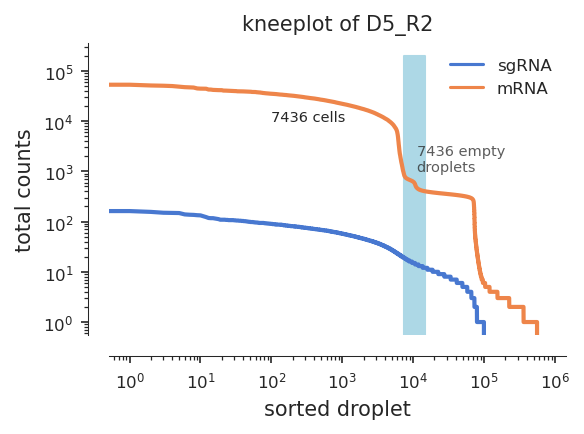

In [40]:
fig = plt.figure(figsize=(4,3))

ax = sns.lineplot(data = rank_UMIs,
             x='rank',
             y='total counts',
             hue='counts',
             markers=False,
             lw=2)

ax.fill_betweenx(y=[0,2e5], x1=n_cells, x2=2*n_cells, color='lightblue')
ax.text(1e2, 1e4, f'{n_cells} cells', fontsize=7);
ax.text(3*n_cells/2, 1e3, f'{n_cells} empty\ndroplets', alpha=0.75, fontsize=7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplet')
ax.legend(loc='upper right', ncol=1, title=None, frameon=False)
ax.set_title('kneeplot of D5_R2')

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

fig.savefig('/da/onc/bfx/research/shengca1/pipeline/obfx-fbdenoiser/manuscript/figures/kneeplot_mRNA_sgRNA_counts.pdf', doi=200)
plt.show()

## systematically check noise level

In [59]:
%%time
noise_rate_df = pd.DataFrame(columns=['mRNA noise ratio',  'fb noise ratio'], index=metadata.index.unique())
for sample in metadata.index.unique():
    cellranger_outs = f'/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/cellranger_count/{sample}/outs/'
    filtered_adata=sc.read_10x_mtx(cellranger_outs + '/filtered_feature_bc_matrix')
    raw_adata=sc.read_10x_mtx(cellranger_outs + '/raw_feature_bc_matrix')
    
    barcodes_real_cells = filtered_adata.obs_names
    n_cells = barcodes_real_cells.shape[0]
    empty_droplets = raw_adata[~raw_adata.obs_names.isin(barcodes_real_cells)]
    
    mRNA_filtered, fb_filtered = split(filtered_adata)
    mRNA_emp, fb_emp = split(empty_droplets, nlargest=n_cells)

    noise_rate_df.loc[sample, 'mRNA noise ratio'] = mRNA_emp.X.sum() / mRNA_filtered.X.sum()
    noise_rate_df.loc[sample, 'fb noise ratio'] = fb_emp.X.sum() / fb_filtered.X.sum()

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


CPU times: user 17min 2s, sys: 15.6 s, total: 17min 18s
Wall time: 7min 39s


In [63]:
noise_rate_df['scRNAseq_tech'] = 'CROPseq 10xV2'

In [134]:
PBMC10k_filtered = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/PBMC10k/filtered_feature_bc_matrix/')
PBMC10k_raw = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/PBMC10k/raw_feature_bc_matrix/')
cb_droplets = PBMC10k_filtered.obs_names
PBMC10k_empties = PBMC10k_raw[~PBMC10k_raw.obs_names.isin(cb_droplets)]
sc.pp.calculate_qc_metrics(PBMC10k_empties, inplace=True)

# Consider only largest cb_droplets.shape[0] droplets
PBMC10k_empties = PBMC10k_empties[PBMC10k_empties.obs['total_counts'].nlargest(len(cb_droplets)).index]

mRNA_nr = PBMC10k_empties.X.sum()/PBMC10k_filtered.X.sum()

PBMC10k_f_filtered = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/PBMC10k/filtered_f_feature_bc_matrix/', gex_only=False)
PBMC10k_f_raw = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/PBMC10k/raw_f_feature_bc_matrix/', gex_only=False)
cb_f_droplets = PBMC10k_f_filtered.obs_names

# Consider only largest cb_f_droplets.shape[0] droplets
PBMC10k_f_empties = PBMC10k_f_raw[~PBMC10k_f_raw.obs_names.isin(cb_f_droplets)]
fb_nr = PBMC10k_f_empties.to_df().sum(axis=1).nlargest(PBMC10k_f_filtered.shape[0]).sum()/PBMC10k_f_filtered.X.sum()

PBMC10k_nr = pd.DataFrame([[mRNA_nr, fb_nr, 'CITEseq 10xV2']], index=['10xPBMC10k'], columns=noise_rate_df.columns)

In [135]:
noise_rate_df = noise_rate_df.append(PBMC10k_nr)

In [136]:
noise_rate_df

,mRNA noise ratio,fb noise ratio,scRNAseq_tech
OE-41-LX17,0.0187747,0.424697,CROPseq 10xV2
KE-42-LB17,0.0425434,0.484297,CROPseq 10xV2
SF-40-AP15,0.0242166,0.312063,CROPseq 10xV2
OF-40-AT15,0.0242709,0.244496,CROPseq 10xV2
KF-40-AX15,0.0259689,0.371296,CROPseq 10xV2
10xPBMC10k,0.00830559,0.235212,CITEseq 10xV2


In [155]:
noise_rate_df.to_pickle('/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/cellranger_count/contamination_rate.pickle')

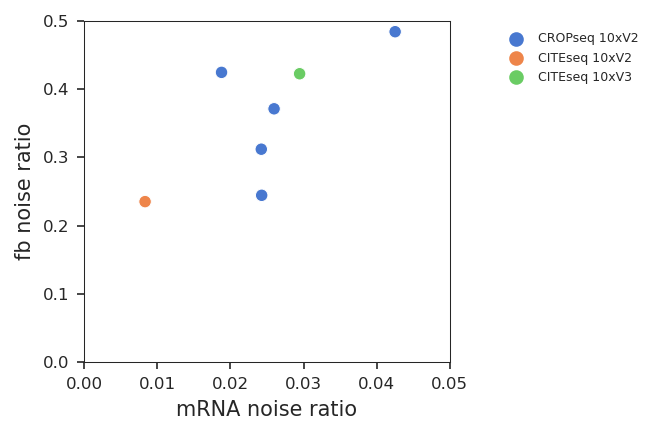

In [189]:
plt.figure(figsize=(5.5,3));
ax = sns.scatterplot(data=noise_rate_df.rename_axis('sample'), x='mRNA noise ratio', y='fb noise ratio', hue='scRNAseq_tech');
ax.legend(loc='best', bbox_to_anchor=(1.05, .5, 0.5, 0.5), ncol=1, title=None, frameon=False, fontsize=6);
ax.set_xlim(0, 0.05);
ax.set_ylim(0, 0.5);
plt.show();

In [164]:
PBMCs_1K_filtered = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/1k_PBMCs_TotalSeq_B_3p/filtered_feature_bc_matrix/', gex_only=False)
PBMCs_1K_raw = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/1k_PBMCs_TotalSeq_B_3p/raw_feature_bc_matrix/', gex_only=False)

In [171]:
def split(adata_obj, nlargest=None):
    
    mRNA = adata_obj[:, adata_obj.var['feature_types'] == 'Gene Expression']   # only mRNA
    fb = adata_obj[:, adata_obj.var['feature_types'] == 'Antibody Capture']   # only sgRNA, Cas9 construct excluded
    if nlargest is not None:
        sc.pp.calculate_qc_metrics(mRNA, inplace=True)
        mRNA = mRNA[mRNA.obs['total_counts'].nlargest(nlargest).index]
        fb = fb[fb.to_df().sum(axis=1).nlargest(nlargest).index]
        
    return mRNA, fb

In [190]:
def get_noise_ratio(filtered_adata, raw_adata):
    barcodes_real_cells = filtered_adata.obs_names
    n_cells = barcodes_real_cells.shape[0]
    empty_droplets = raw_adata[~raw_adata.obs_names.isin(barcodes_real_cells)]

    mRNA_filtered, fb_filtered = split(filtered_adata)
    mRNA_emp, fb_emp = split(empty_droplets, nlargest=n_cells)
    mRNA_nr = mRNA_emp.X.sum() / mRNA_filtered.X.sum()
    fb_nr = fb_emp.X.sum() / fb_filtered.X.sum()
    
    return mRNA_nr, fb_nr

In [191]:
mRNA_nr, fb_nr = get_noise_ratio(PBMCs_1K_filtered, PBMCs_1K_raw)

Trying to set attribute `.obs` of view, copying.


In [ ]:
PBMC_1K_nr = pd.DataFrame([[mRNA_nr, fb_nr, 'CITEseq 10xV3']], index=['10xPBMC1k'], columns=noise_rate_df.columns)

In [188]:
noise_rate_df = noise_rate_df.append(PBMC_1K_nr)
noise_rate_df.to_pickle('/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/cellranger_count/contamination_rate.pickle')
noise_rate_df

,mRNA noise ratio,fb noise ratio,scRNAseq_tech
OE-41-LX17,0.0187747,0.424697,CROPseq 10xV2
KE-42-LB17,0.0425434,0.484297,CROPseq 10xV2
SF-40-AP15,0.0242166,0.312063,CROPseq 10xV2
OF-40-AT15,0.0242709,0.244496,CROPseq 10xV2
KF-40-AX15,0.0259689,0.371296,CROPseq 10xV2
10xPBMC10k,0.00830559,0.235212,CITEseq 10xV2
10xPBMC1k,0.0294656,0.422677,CITEseq 10xV3


In [194]:
PBMCs10K_TotalSeq_B_3p_filtered = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/10k_PBMCs_TotalSeq_B_3p/filtered_feature_bc_matrix/', gex_only=False)
PBMCs10K_TotalSeq_B_3p_raw = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/10k_PBMCs_TotalSeq_B_3p/raw_feature_bc_matrix/', gex_only=False)

In [203]:
mRNA_nr, fb_nr = get_noise_ratio(PBMCs10K_TotalSeq_B_3p_filtered, PBMCs10K_TotalSeq_B_3p_raw)

Trying to set attribute `.obs` of view, copying.


In [204]:
PBMC_10K_nr = pd.DataFrame([[mRNA_nr, fb_nr, 'CITEseq 10xV3']], index=['10xPBMC10k_TBNK'], columns=noise_rate_df.columns)

In [228]:
# noise_rate_df = noise_rate_df.append(PBMC_10K_nr)
noise_rate_df.to_pickle('/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/cellranger_count/contamination_rate.pickle')
# noise_rate_df

In [222]:
noise_rate_df.rename(index={'OE-41-LX17': 'MCF7 D5R1',
                            'KE-42-LB17':'MCF7 D5R2', 
                            'SF-40-AP15':'MCF7 D12R1', 
                            'OF-40-AT15':'MCF7 D12R2', 
                            'KF-40-AX15':'MCF7 D12R3'}, inplace=True)

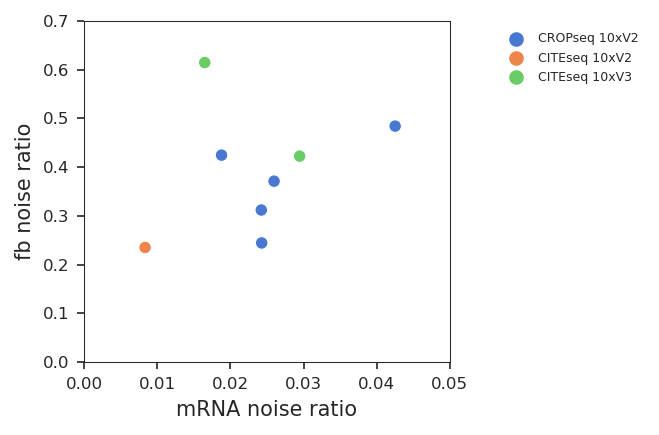

In [227]:
plt.figure(figsize=(5.5,3));
ax = sns.scatterplot(data=noise_rate_df.rename_axis('sample'), x='mRNA noise ratio', y='fb noise ratio',  hue='scRNAseq_tech'); #style='scRNAseq_tech',
ax.legend(loc='best', bbox_to_anchor=(1.05, .5, 0.5, 0.5), ncol=1, title=None, frameon=False, fontsize=6);
ax.set_xlim(0, 0.05);
ax.set_ylim(0, 0.7);
plt.show();

In [226]:
noise_rate_df

,mRNA noise ratio,fb noise ratio,scRNAseq_tech
MCF7 D5R1,0.0187747,0.424697,CROPseq 10xV2
MCF7 D5R2,0.0425434,0.484297,CROPseq 10xV2
MCF7 D12R1,0.0242166,0.312063,CROPseq 10xV2
MCF7 D12R2,0.0242709,0.244496,CROPseq 10xV2
MCF7 D12R3,0.0259689,0.371296,CROPseq 10xV2
10xPBMC10k,0.00830559,0.235212,CITEseq 10xV2
10xPBMC1k,0.0294656,0.422677,CITEseq 10xV3
10xPBMC10k_TBNK,0.0164736,0.614636,CITEseq 10xV3


In [229]:
pbmc_5k_protein_v3_filtered = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/5k_pbmc_protein_v3/filtered_feature_bc_matrix/', gex_only=False)
pbmc_5k_protein_v3_raw = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/5k_pbmc_protein_v3/raw_feature_bc_matrix/', gex_only=False)

In [230]:
mRNA_nr, fb_nr = get_noise_ratio(pbmc_5k_protein_v3_filtered, pbmc_5k_protein_v3_raw)

Trying to set attribute `.obs` of view, copying.


In [231]:
pbmc_5k_protein_v3_nr = pd.DataFrame([[mRNA_nr, fb_nr, 'CITEseq 10xV3']], index=['10xPBMC1k'], columns=noise_rate_df.columns)

In [232]:
pbmc_5k_protein_v3_nr

,mRNA noise ratio,fb noise ratio,scRNAseq_tech
10xPBMC1k,0.016885,0.060728,CITEseq 10xV3


In [233]:
noise_rate_df.append(pbmc_5k_protein_v3_nr)

,mRNA noise ratio,fb noise ratio,scRNAseq_tech
MCF7 D5R1,0.0187747,0.424697,CROPseq 10xV2
MCF7 D5R2,0.0425434,0.484297,CROPseq 10xV2
MCF7 D12R1,0.0242166,0.312063,CROPseq 10xV2
MCF7 D12R2,0.0242709,0.244496,CROPseq 10xV2
MCF7 D12R3,0.0259689,0.371296,CROPseq 10xV2
10xPBMC10k,0.00830559,0.235212,CITEseq 10xV2
10xPBMC1k,0.0294656,0.422677,CITEseq 10xV3
10xPBMC10k_TBNK,0.0164736,0.614636,CITEseq 10xV3
10xPBMC1k,0.016885,0.0607283,CITEseq 10xV3


In [ ]:
noise_rate_df = noise_rate_df.append(pbmc_5k_protein_v3_nr)
noise_rate_df.to_pickle('/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/cellranger_count/contamination_rate.pickle')
# noise_rate_df

In [236]:
malt_10k_protein_v3_filtered = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/malt_10k_protein_v3/filtered_feature_bc_matrix/', gex_only=False)
malt_10k_protein_v3_raw = sc.read_10x_mtx('/da/onc/bfx/research/shengca1/public_data/10xgenomics/malt_10k_protein_v3/raw_feature_bc_matrix/', gex_only=False)

In [237]:
mRNA_nr, fb_nr = get_noise_ratio(malt_10k_protein_v3_filtered, malt_10k_protein_v3_raw)
malt_10k_protein_v3_nr = pd.DataFrame([[mRNA_nr, fb_nr, 'CITEseq 10xV3']], index=['10xMALT10K'], columns=noise_rate_df.columns)

Trying to set attribute `.obs` of view, copying.


In [238]:
noise_rate_df.append(malt_10k_protein_v3_nr)

,mRNA noise ratio,fb noise ratio,scRNAseq_tech
MCF7 D5R1,0.0187747,0.424697,CROPseq 10xV2
MCF7 D5R2,0.0425434,0.484297,CROPseq 10xV2
MCF7 D12R1,0.0242166,0.312063,CROPseq 10xV2
MCF7 D12R2,0.0242709,0.244496,CROPseq 10xV2
MCF7 D12R3,0.0259689,0.371296,CROPseq 10xV2
10xPBMC10k,0.00830559,0.235212,CITEseq 10xV2
10xPBMC1k,0.0294656,0.422677,CITEseq 10xV3
10xPBMC10k_TBNK,0.0164736,0.614636,CITEseq 10xV3
10xMALT10K,0.0501713,0.171998,CITEseq 10xV3


In [239]:
noise_rate_df = noise_rate_df.append(malt_10k_protein_v3_nr)
noise_rate_df.to_pickle('/da/onc/BFx/research/shengca1/bioinfo_pipeline/intra_cropseq/Second/final/cellranger_count/contamination_rate.pickle')
# noise_rate_df

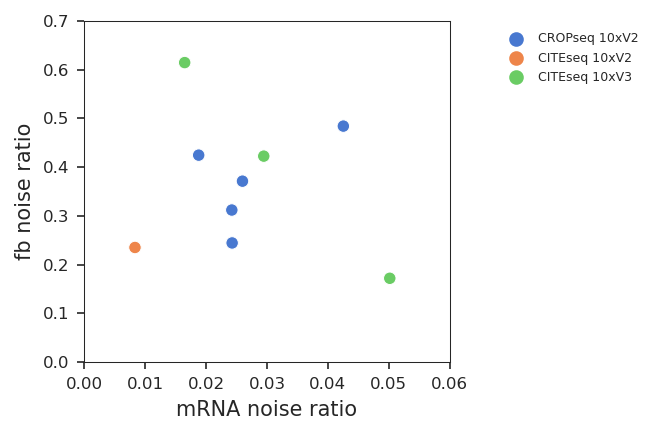

In [242]:
plt.figure(figsize=(5.5,3));
ax = sns.scatterplot(data=noise_rate_df.rename_axis('sample'), x='mRNA noise ratio', y='fb noise ratio',  hue='scRNAseq_tech'); #style='scRNAseq_tech',
ax.legend(loc='best', bbox_to_anchor=(1.05, .5, 0.5, 0.5), ncol=1, title=None, frameon=False, fontsize=6);
ax.set_xlim(0, 0.06);
ax.set_ylim(0, 0.7);
plt.show();